In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [88]:
df = pd.read_csv('../datasets/clean_dataset.csv')

RANDOM_SEED=42

### Algorithm selection

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

In [90]:
features = ['close_loans_cnt','federal_district_nm','TraderKey','payment_type_0','payment_type_1','payment_type_2','payment_type_3','payment_type_4','past_billings_cnt','score_1','age','gender','diff_loans']
target = 'bad_flag'

In [91]:

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=RANDOM_SEED)

In [92]:
print(X_train.shape)
print(X_test.shape)

(3316, 13)
(830, 13)


In [93]:
classifiers = [
    KNeighborsClassifier(),
    LogisticRegression(random_state=RANDOM_SEED),
    BaggingClassifier(random_state=RANDOM_SEED),
    GaussianNB(),
    RandomForestClassifier(n_estimators=100,random_state=RANDOM_SEED),
    ExtraTreesClassifier(n_estimators=100,random_state=RANDOM_SEED)
]

## 1. Experiment 2

#### SMOTE

In [94]:
from imblearn.over_sampling import SMOTE

In [95]:
clases_contadas = pd.Series(y_train).value_counts()
print("Classes before oversampling:")
print(clases_contadas)

Classes before oversampling:
bad_flag
0    2984
1     332
Name: count, dtype: int64


In [96]:
smote = SMOTE(sampling_strategy='auto', random_state=RANDOM_SEED)

X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

# Contar las clases después del oversampling
n_classes = pd.Series(y_train_oversampled).value_counts()
print("Number of classes after oversampling:")
print(n_classes)

Number of classes after oversampling:
bad_flag
0    2984
1    2984
Name: count, dtype: int64


In [97]:
# over_X_train,over_X_test,over_y_train,over_y_test = train_test_split(X_train_oversampled,y_train_oversampled,test_size=0.2,random_state=RANDOM_SEED)

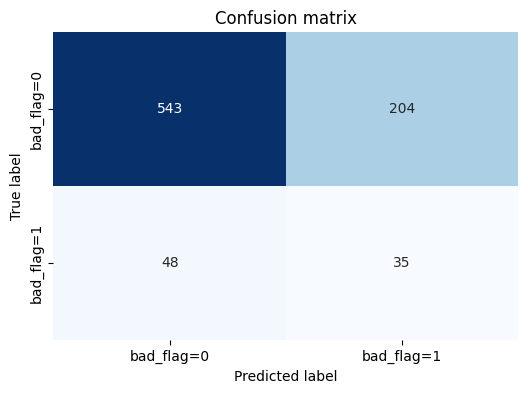

KNeighborsClassifier  f1 score: 0.21739130434782608


d:\Documentos\Proyectos\Data science escritorio\Data science\StrataScratch\CLASIFICACION\Flagging Loans - Mokka\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


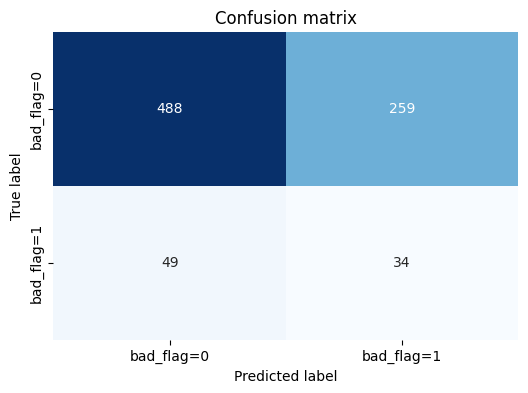

LogisticRegression  f1 score: 0.18085106382978727


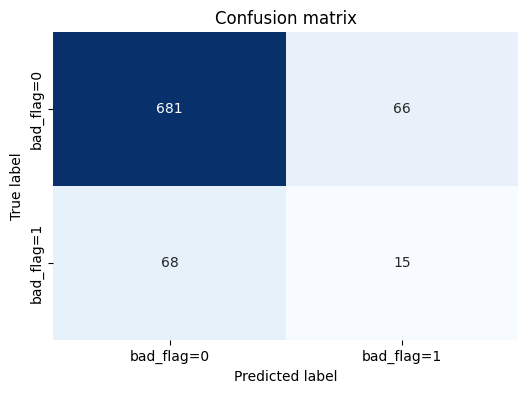

BaggingClassifier  f1 score: 0.1829268292682927


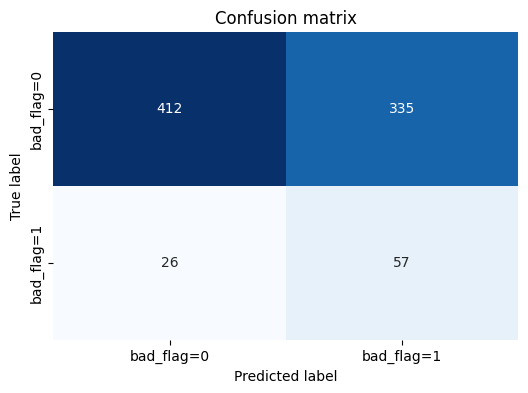

GaussianNB  f1 score: 0.24


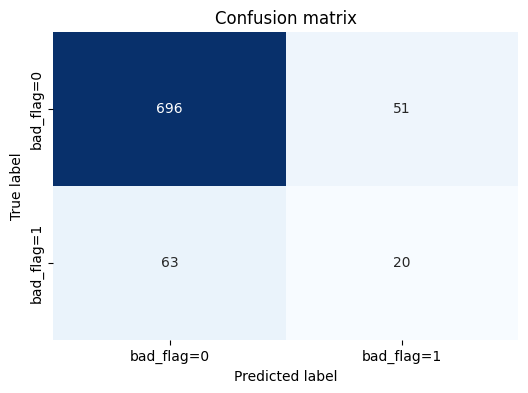

RandomForestClassifier  f1 score: 0.25974025974025977


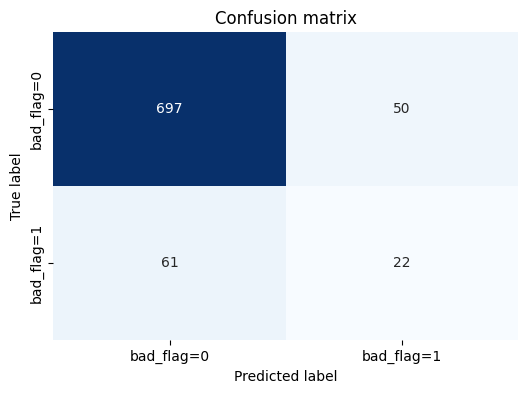

ExtraTreesClassifier  f1 score: 0.28387096774193554


In [98]:
for classifier in classifiers:
    classifier.fit(X=X_train_oversampled, y=y_train_oversampled)
    y_pred = classifier.predict(X=X_test)
    f1 = f1_score(y_true=y_test, y_pred=y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Definir etiquetas de clase
    classes=["bad_flag=0", "bad_flag=1"]

    # Crear mapa de calor de la matriz de confusión
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)

    plt.title('Confusion matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
    
    print(classifier.__class__.__name__, " f1 score:", f1)

The best f1 score has been obtained by the RandomForest algorithm so we are going to use the hyperparameter optimization:

In [99]:
import optuna 
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score


In [100]:
def objective2(trial: optuna.Trial):

    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    # min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    # min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 0.5)


    RFC = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        # min_samples_split=min_samples_split,
        # min_samples_leaf=min_samples_leaf,
        random_state=RANDOM_SEED
    )

    classifier = RFC.fit(X=X_train_oversampled, y=y_train_oversampled)
    y_pred = classifier.predict(X=X_test)

    return f1_score(y_true=y_test, y_pred=y_pred)

In [101]:
sampler=optuna.samplers.TPESampler()
study = optuna.create_study(direction="maximize",study_name="RandomForest_SMOTE",sampler=sampler)
study.optimize(objective2, n_trials=20)

print("Best F1-score: ", study.best_value)
print("Best params: ", study.best_params)

[I 2023-08-02 12:17:11,637] A new study created in memory with name: RandomForest_SMOTE
[I 2023-08-02 12:17:12,049] Trial 0 finished with value: 0.18181818181818182 and parameters: {'n_estimators': 161, 'max_depth': 8, 'min_samples_split': 0.872787978480158, 'min_samples_leaf': 0.21292340704385115}. Best is trial 0 with value: 0.18181818181818182.
[I 2023-08-02 12:17:12,530] Trial 1 finished with value: 0.24064171122994651 and parameters: {'n_estimators': 179, 'max_depth': 7, 'min_samples_split': 0.16909753689309392, 'min_samples_leaf': 0.2763683172637976}. Best is trial 1 with value: 0.24064171122994651.
[I 2023-08-02 12:17:12,940] Trial 2 finished with value: 0.25994694960212206 and parameters: {'n_estimators': 148, 'max_depth': 9, 'min_samples_split': 0.5654839486352028, 'min_samples_leaf': 0.1281382061846868}. Best is trial 2 with value: 0.25994694960212206.
[I 2023-08-02 12:17:13,078] Trial 3 finished with value: 0.18181818181818182 and parameters: {'n_estimators': 62, 'max_depth'

Best F1-score:  0.2893081761006289
Best params:  {'n_estimators': 81, 'max_depth': 6, 'min_samples_split': 0.4664728875956423, 'min_samples_leaf': 0.14665159108642795}


In [102]:
study.best_params

{'n_estimators': 81,
 'max_depth': 6,
 'min_samples_split': 0.4664728875956423,
 'min_samples_leaf': 0.14665159108642795}

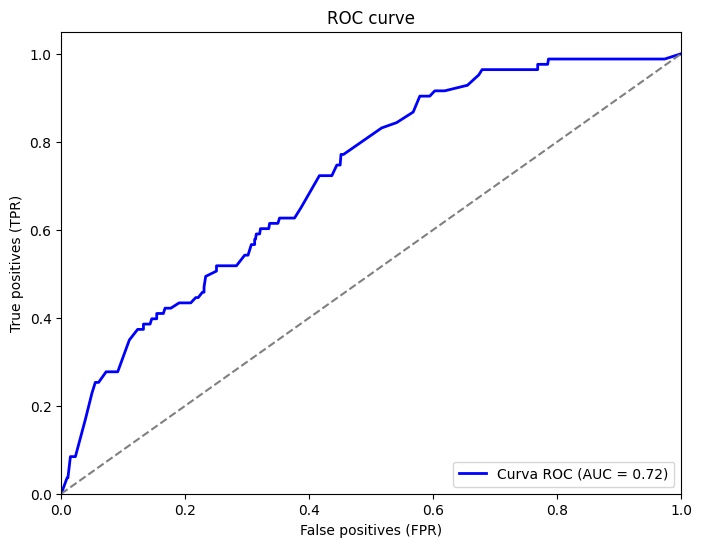

In [103]:
# 
clf2 = RandomForestClassifier(**study.best_params)

clf2.fit(X_train_oversampled, y_train_oversampled)
y_probs = clf2.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positives (FPR)')
plt.ylabel('True positives (TPR)')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [104]:
roc_auc

0.7191093692037226

In [105]:
y_pred = clf2.predict(X=X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Exactitud (Accuracy):", accuracy)

# Precisión (Precision)
precision = precision_score(y_test, y_pred)
print("Precisión (Precision):", precision)

# Recuperación o Sensibilidad (Recall)
recall = recall_score(y_test, y_pred)
print("Recuperación o Sensibilidad (Recall):", recall)

# F1-score
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

Exactitud (Accuracy): 0.6734939759036145
Precisión (Precision): 0.17132867132867133
Recuperación o Sensibilidad (Recall): 0.5903614457831325
F1-score: 0.26558265582655827


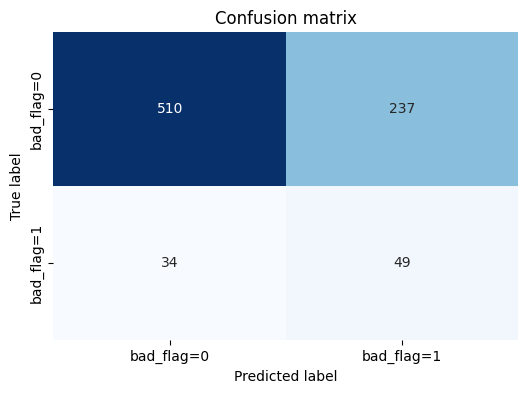

In [106]:
cm = confusion_matrix(y_test, y_pred)

# Definir etiquetas de clase
classes=["bad_flag=0", "bad_flag=1"]

# Crear mapa de calor de la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)

plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()